<a href="https://colab.research.google.com/github/jgbrenner/psychometrics/blob/main/PsychometriaC9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generating Psychometric Scale Items in Polish Measuring Perfectionism Using Generative AI and Conducting Exploratory Graph Analysis**



# Methodology

# Overview

In this notebook, I will utilize a large language model (LLM) to generate items for a psychometric scale measuring three dimensions of perfectionism: Self-Oriented Perfectionism, Other-Oriented Perfectionism, and Socially Conditioned Perfectionism. Following item generation, I will perform Exploratory Graph Analysis (EGA) to validate the structure and dimensionality of the generated items.


# Steps Involved

Item Generation:
I prompted the LLM to generate six items for each construct. The output was formatted in JSON for easy processing.
The constructs targeted are:

- Self-Oriented Perfectionism

- Other-Oriented Perfectionism

- Socially Conditioned Perfectionism


# Data Preparation:

The generated items were compiled into a data frame, and constructs were extracted for further analysis.
An embeddings array was created to represent the items in a high-dimensional space suitable for EGA.

# Transfer to R:

The embeddings array and constructs list were transferred from Python to R using the rpy2 interface.

# Exploratory Graph Analysis (EGA):

In R, the embeddings array was converted into a matrix format, with appropriate row names assigned based on the constructs.
The EGAnet library was utilized to perform EGA on the embeddings matrix, allowing for an exploration of the underlying structure of the psychometric items.

Results were printed and visualized to assess the dimensionality of the constructs.

# Conclusion
This methodology enables a systematic approach to generating and validating psychometric scale items, ensuring that they are both relevant and statistically sound.

In [1]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 2.2 MB/s eta 0:00:00


In [2]:
# Load the R magic extension for rpy2
%load_ext rpy2.ipython

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path where the R library will be saved in Google Drive
library_path = '/content/drive/MyDrive/R_libraries'

# Create the directory if it doesn't exist
if not os.path.exists(library_path):
    os.makedirs(library_path)

Mounted at /content/drive


In [3]:
#verify rpy2 version as this is known to cause errors ( ver 3.4.2 works fine )
import rpy2
print(f"rpy2 version: {rpy2.__version__}")

rpy2 version: 3.4.2


In [4]:
%%R -i library_path

# Set the custom library path to persist during the Colab session
.libPaths(library_path)

# Set CRAN repository globally
options(repos = c(CRAN = "https://cloud.r-project.org"))

# List of required R packages
required_packages <- c("gmp", "Rmpfr", "CVXR", "fungible", "EGAnet")

# Install each package only if it's not already installed
for (pkg in required_packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg, lib = library_path, dependencies = TRUE)
    }
}

# Load EGAnet library
library(EGAnet)


EGAnet (version 2.1.0) 

For help getting started, see <https://r-ega.net> 

For bugs and errors, submit an issue to <https://github.com/hfgolino/EGAnet/issues>



In [5]:
# Import necessary Python libraries
import openai
import pandas as pd
import numpy as np
import json
import requests
import re


from google.colab import userdata

#fetching the OpenAI API key from secrets
openai_api_key = userdata.get('OPENAI_API_KEY')

from groq import Groq

#fetching the Groq API key from secrets
groq_api_key = userdata.get('GROQ_API_KEY')

# Initialize the Groq client
client = Groq(api_key=groq_api_key)

# Prompting is everything.
I was able to prompt the Gpt-4o-mini model into generating scale items

In [67]:

client = Client()

messages = [
    {
        "role": "system",
        "content": "Jesteś ekspertem w psychometrii, który tworzy pytania testowe."
    },
    {
        "role": "user",
        "content": (
            "Wygeneruj po sześć pytań dla każdego z następujących konstruktów: "
            "Perfekcjonizm skierowany na siebie: Tendencja do wymagania doskonałości od siebie samego, "
            "Perfekcjonizm skierowany na innych: Stawianie wysokich oczekiwań wobec innych i krytyczna ocena ich osiągnięć, "
            "Perfekcjonizm społecznie narzucony: Przekonanie, że inni oczekują od nas doskonałości. "
            "Niech będą zwięzłe i jasne. "
            "Provide the output ONLY in JSON format as a list of dictionaries, "
            "without any additional text or explanation. "
            "Each dictionary should have keys 'construct', 'item', and 'type' (either 'regular-keyed' or 'reverse-keyed')."

        )
    }
]

try:
    # Create the completion request
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.5,
        max_tokens=2048,
        top_p=1,
        stream=False,  # Disable streaming for simplicity
        stop=None,
    )
   # Collect the response content
    response_content = completion.choices[0].message.content
    print("\nLLM Output:\n", response_content)

except Exception as e:
    print(f"An error occurred: {e}")
    response_content = ""



LLM Output:
 ```json
[
    {
        "construct": "Perfekcjonizm skierowany na siebie",
        "item": "Czuję, że muszę być doskonały we wszystkim, co robię.",
        "type": "regular-keyed"
    },
    {
        "construct": "Perfekcjonizm skierowany na siebie",
        "item": "Często czuję się zawiedziony, gdy nie osiągam swoich wysokich standardów.",
        "type": "regular-keyed"
    },
    {
        "construct": "Perfekcjonizm skierowany na siebie",
        "item": "Nawet drobne błędy wywołują u mnie silny dyskomfort.",
        "type": "regular-keyed"
    },
    {
        "construct": "Perfekcjonizm skierowany na siebie",
        "item": "Czuję, że muszę być lepszy od innych, aby móc się czuć spełniony.",
        "type": "regular-keyed"
    },
    {
        "construct": "Perfekcjonizm skierowany na siebie",
        "item": "Często porównuję się z innymi, aby ocenić swoje osiągnięcia.",
        "type": "regular-keyed"
    },
    {
        "construct": "Perfekcjonizm skierowany 

In [68]:
# Parse the JSON response
try:
    generated_items = json.loads(response_content)
    items_df = pd.DataFrame(generated_items)
except json.JSONDecodeError as e:
    print(f"JSON decoding failed: {e}")
    # Attempt to extract JSON content from the response
    json_match = re.search(r'\[.*\]', response_content, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        try:
            generated_items = json.loads(json_str)
            items_df = pd.DataFrame(generated_items)
        except json.JSONDecodeError as e2:
            print(f"Second JSON decoding attempt failed: {e2}")
            items_df = None
    else:
        print("No JSON content found in the response.")
        items_df = None

# Check if items_df is defined
if items_df is not None:
    # Save to CSV (optional)
    items_df.to_csv("perfectionism_items.csv", index=False)
    print("Items saved to 'perfectionism_items.csv'.")

    # Prepare the list of items
    item_texts = items_df["item"].tolist()

    # Ensure item_texts is clean and valid
    item_texts = [item for item in item_texts if item.strip()]  # Filter empty strings

    # Set up the API endpoint and headers for OpenAI embeddings
    embedding_endpoint = "https://api.openai.com/v1/embeddings"
    embedding_model = "text-embedding-3-small"  # Using a commonly available model

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }

    # Prepare the data payload
    data = {
        "model": embedding_model,
        "input": item_texts
    }

    # Make the API request
    try:
        response = requests.post(embedding_endpoint, headers=headers, json=data)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        else:
            response_data = response.json()
            # Extract embeddings
            embeddings = [item['embedding'] for item in response_data['data']]
            embeddings_array = np.array(embeddings)
            print(f"Embeddings generated successfully. Shape: {embeddings_array.shape}")
            # Save the embeddings
            np.save("embeddings.npy", embeddings_array)
            print("Embeddings saved as 'embeddings.npy'.")
    except Exception as e:
        print(f"An error occurred during embedding generation: {e}")
else:
    print("Error: items_df is not defined. Cannot proceed with embedding generation.")



JSON decoding failed: Expecting value: line 1 column 1 (char 0)
Items saved to 'perfectionism_items.csv'.
Embeddings generated successfully. Shape: (18, 1536)
Embeddings saved as 'embeddings.npy'.


In [69]:
# Define custom abbreviations for constructs
construct_abbreviations = {
    "Perfekcjonizm skierowany na siebie": "PSS",
    "Perfekcjonizm społecznie narzucony": "PSP",
    "Perfekcjonizm skierowany na innych": "PSI"
}

# Apply custom labels with error handling for unexpected constructs
items_df['item_label'] = items_df.apply(
    lambda row: f"{construct_abbreviations.get(row['construct'], 'UNK')}{row.name+1}", axis=1
)

# Verify the generated labels
items_constructs = items_df['item_label'].tolist()
print("Generated Item Labels:", items_constructs)

# Transfer data to R
%R -i embeddings_array -i items_constructs


Generated Item Labels: ['PSS1', 'PSS2', 'PSS3', 'PSS4', 'PSS5', 'PSS6', 'PSI7', 'PSI8', 'PSI9', 'PSI10', 'PSI11', 'PSI12', 'PSP13', 'PSP14', 'PSP15', 'PSP16', 'PSP17', 'PSP18']


In [73]:
# Combine item labels with their respective text
labeled_items = items_df.apply(
    lambda row: f"{row['item_label']}: {row['item']}", axis=1
).tolist()

# Print the list of labeled items
print("Labeled Items List:")
for item in labeled_items:
    print(item)

Labeled Items List:
PSS1: Czuję, że muszę być doskonały we wszystkim, co robię.
PSS2: Często czuję się zawiedziony, gdy nie osiągam swoich wysokich standardów.
PSS3: Nawet drobne błędy wywołują u mnie silny dyskomfort.
PSS4: Czuję, że muszę być lepszy od innych, aby móc się czuć spełniony.
PSS5: Często porównuję się z innymi, aby ocenić swoje osiągnięcia.
PSS6: Uważam, że nie mogę sobie pozwolić na porażkę.
PSI7: Oczekuję, że inni będą wykonywać swoje zadania perfekcyjnie.
PSI8: Krytycznie oceniam osiągnięcia innych ludzi.
PSI9: Często czuję, że inni mogą zrobić coś lepiej niż ja.
PSI10: Nie toleruję błędów popełnianych przez innych.
PSI11: Czuję się sfrustrowany, gdy inni nie spełniają moich oczekiwań.
PSI12: Często wyrażam swoje niezadowolenie z pracy innych.
PSP13: Czuję, że inni oczekują ode mnie doskonałości.
PSP14: Mam wrażenie, że muszę spełniać wysokie oczekiwania innych.
PSP15: Czuję presję, aby być idealnym w oczach innych.
PSP16: Czasami obawiam się, że zawiodę oczekiwania i

In [70]:
%%R
# Convert embeddings_array to a matrix
embeddings_matrix <- as.matrix(embeddings_array)

# Assign row names to the matrix
rownames(embeddings_matrix) <- items_constructs

# Compute the correlation matrix between items
cor_matrix <- cor(t(embeddings_matrix))



Print correlation matrix heatmap

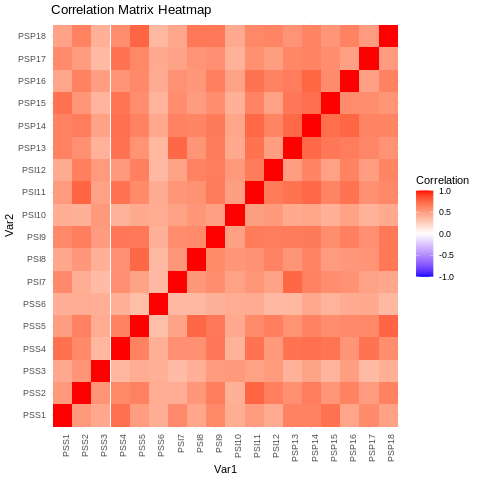

In [71]:
%%R

library(ggplot2)
library(reshape2)

# Melt the correlation matrix for plotting
heatmap_data <- melt(cor_matrix)

# Create a heatmap
ggplot(heatmap_data, aes(Var1, Var2, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", limit = c(-1, 1), name="Correlation") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Correlation Matrix Heatmap")

## **EGA result**

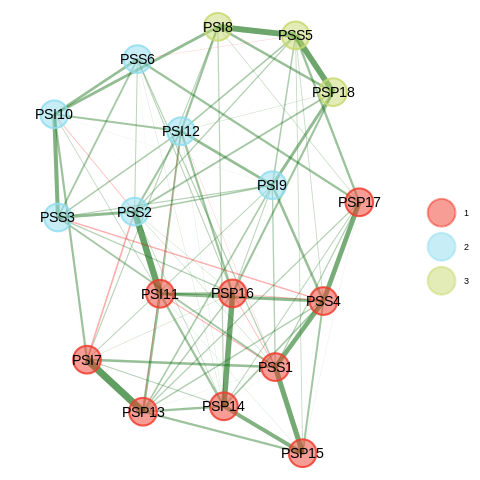

In [75]:
%%R

# Load EGAnet library
library(EGAnet)

# Perform EGA analysis with adjusted parameters
ega_result <- EGA(
    data = cor_matrix,
    n = 1000,                # Set a hypothetical sample size
    corr = "auto",           # Indicate that data is a correlation matrix
    model = "glasso",
    lambda.min.ratio = 0.001,    # Reduce lambda.min.ratio
    args.glasso = list(gamma = 0.05),  # Reduce gamma for sensitivity
    plot.EGA = TRUE,
    verbose = TRUE
)








    "Perfekcjonizm skierowany na siebie": "PSS",
    "Perfekcjonizm społecznie narzucony": "PSP",
    "Perfekcjonizm skierowany na innych": "PSI"

In [76]:
%%R
print(cor_matrix)

           PSS1      PSS2      PSS3      PSS4      PSS5      PSS6      PSI7
PSS1  1.0000000 0.5248099 0.4490376 0.7125962 0.5069464 0.4179669 0.5942429
PSS2  0.5248099 1.0000000 0.5482611 0.5966289 0.6378226 0.4293356 0.4180166
PSS3  0.4490376 0.5482611 1.0000000 0.3718886 0.4276026 0.4138202 0.3545971
PSS4  0.7125962 0.5966289 0.3718886 1.0000000 0.6311753 0.4150178 0.5703124
PSS5  0.5069464 0.6378226 0.4276026 0.6311753 1.0000000 0.3406886 0.4749610
PSS6  0.4179669 0.4293356 0.4138202 0.4150178 0.3406886 1.0000000 0.3692613
PSI7  0.5942429 0.4180166 0.3545971 0.5703124 0.4749610 0.3692613 1.0000000
PSI8  0.4613244 0.5306520 0.4090583 0.5651145 0.7497354 0.3700985 0.5266267
PSI9  0.6042044 0.6527710 0.5074164 0.6821411 0.6788257 0.4073797 0.5812689
PSI10 0.4256946 0.4054301 0.5220019 0.3996900 0.4412795 0.4310021 0.4833188
PSI11 0.5149865 0.7614116 0.4869343 0.7001341 0.5923259 0.4365053 0.5398392
PSI12 0.4355064 0.6486190 0.5184525 0.5247976 0.6488678 0.3667619 0.4766786
PSP13 0.6315

In [77]:
%%R

# Summary statistics of the correlation matrix
summary(cor_matrix)

      PSS1             PSS2             PSS3             PSS4       
 Min.   :0.4180   Min.   :0.4054   Min.   :0.3546   Min.   :0.3719  
 1st Qu.:0.4623   1st Qu.:0.5263   1st Qu.:0.4034   1st Qu.:0.5502  
 Median :0.5199   Median :0.5822   Median :0.4383   Median :0.6139  
 Mean   :0.5636   Mean   :0.5942   Mean   :0.4748   Mean   :0.6165  
 3rd Qu.:0.6214   3rd Qu.:0.6459   3rd Qu.:0.5058   3rd Qu.:0.6997  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      PSS5             PSS6             PSI7             PSI8       
 Min.   :0.3407   Min.   :0.3407   Min.   :0.3546   Min.   :0.3701  
 1st Qu.:0.5191   1st Qu.:0.3706   1st Qu.:0.4742   1st Qu.:0.5275  
 Median :0.6015   Median :0.4144   Median :0.5332   Median :0.5442  
 Mean   :0.6033   Mean   :0.4365   Mean   :0.5463   Mean   :0.5751  
 3rd Qu.:0.6461   3rd Qu.:0.4325   3rd Qu.:0.5810   3rd Qu.:0.6121  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      PSI9            PSI10       

In [78]:
%%R

pca_result <- prcomp(cor_matrix, scale. = TRUE)
summary(pca_result)


Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.5152 1.9134 1.3759 1.24745 1.02016 0.83186 0.75574
Proportion of Variance 0.3515 0.2034 0.1052 0.08645 0.05782 0.03844 0.03173
Cumulative Proportion  0.3515 0.5549 0.6600 0.74648 0.80430 0.84274 0.87447
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.69650 0.64103 0.59902 0.53656 0.43603 0.38914 0.35876
Proportion of Variance 0.02695 0.02283 0.01993 0.01599 0.01056 0.00841 0.00715
Cumulative Proportion  0.90142 0.92425 0.94419 0.96018 0.97074 0.97915 0.98631
                          PC15    PC16    PC17      PC18
Standard deviation     0.31657 0.28409 0.25607 3.989e-17
Proportion of Variance 0.00557 0.00448 0.00364 0.000e+00
Cumulative Proportion  0.99187 0.99636 1.00000 1.000e+00


In [79]:
%%R

high_correlations <- which(abs(cor_matrix) > 0.5 & lower.tri(cor_matrix), arr.ind = TRUE)
high_correlations_df <- as.data.frame(high_correlations)

# Display item pairs with high correlations
print(high_correlations_df)

         row col
PSS2       2   1
PSS4       4   1
PSS5       5   1
PSI7       7   1
PSI9       9   1
PSI11     11   1
PSP13     13   1
PSP14     14   1
PSP15     15   1
PSP17     17   1
PSS3       3   2
PSS4.1     4   2
PSS5.1     5   2
PSI8       8   2
PSI9.1     9   2
PSI11.1   11   2
PSI12     12   2
PSP13.1   13   2
PSP14.1   14   2
PSP15.1   15   2
PSP16     16   2
PSP17.1   17   2
PSP18     18   2
PSI9.2     9   3
PSI10     10   3
PSI12.1   12   3
PSP16.1   16   3
PSS5.2     5   4
PSI7.1     7   4
PSI8.1     8   4
PSI9.3     9   4
PSI11.2   11   4
PSI12.2   12   4
PSP13.2   13   4
PSP14.2   14   4
PSP15.2   15   4
PSP16.2   16   4
PSP17.2   17   4
PSP18.1   18   4
PSI8.2     8   5
PSI9.4     9   5
PSI11.3   11   5
PSI12.3   12   5
PSP13.3   13   5
PSP14.3   14   5
PSP15.3   15   5
PSP16.3   16   5
PSP17.3   17   5
PSP18.2   18   5
PSI8.3     8   7
PSI9.5     9   7
PSI11.4   11   7
PSP13.4   13   7
PSP14.4   14   7
PSP15.4   15   7
PSP16.4   16   7
PSI9.6     9   8
PSI10.1   10  

#Performing  Exploratory Factor Analysis

Attaching package: ‘psych’



    %+%, alpha




Factor Analysis using method =  ml
Call: fa(r = cor_matrix, nfactors = 3, rotate = "varimax", fm = "ml")
Standardized loadings (pattern matrix) based upon correlation matrix
       ML3  ML1  ML2   h2   u2 com
PSS1  0.74 0.22 0.25 0.65 0.35 1.4
PSS2  0.33 0.63 0.39 0.66 0.34 2.3
PSS3  0.22 0.54 0.23 0.39 0.61 1.7
PSS4  0.73 0.30 0.36 0.75 0.25 1.8
PSS5  0.34 0.32 0.81 0.87 0.13 1.7
PSS6  0.33 0.38 0.16 0.28 0.72 2.3
PSI7  0.62 0.36 0.19 0.55 0.45 1.8
PSI8  0.33 0.35 0.64 0.65 0.35 2.1
PSI9  0.48 0.49 0.45 0.67 0.33 3.0
PSI10 0.28 0.45 0.28 0.36 0.64 2.4
PSI11 0.47 0.67 0.27 0.75 0.25 2.2
PSI12 0.23 0.62 0.47 0.66 0.34 2.2
PSP13 0.70 0.44 0.21 0.74 0.26 1.9
PSP14 0.61 0.56 0.30 0.77 0.23 2.5
PSP15 0.70 0.32 0.28 0.67 0.33 1.7
PSP16 0.38 0.68 0.29 0.70 0.30 2.0
PSP17 0.59 0.25 0.40 0.58 0.42 2.1
PSP18 0.30 0.44 0.64 0.69 0.31 2.3

                       ML3  ML1  ML2
SS loadings           4.49 3.94 2.98
Proportion Var        0.25 0.22 0.17
Cumulative Var        0.25 0.47 0.63
Proportion E

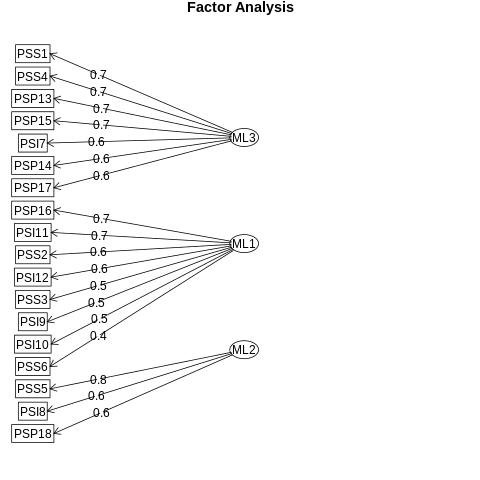

In [80]:
%%R

# Load necessary library
library(psych)

# Perform Exploratory Factor Analysis
efa_result <- fa(
    r = cor_matrix,         # Use the correlation matrix
    nfactors = 3,           # Hypothesized number of factors (3 constructs)
    rotate = "varimax",     # Use varimax rotation for interpretability
    fm = "ml"               # Use maximum likelihood extraction
)

# Print EFA results
print(efa_result)

# Visualize factor loadings
fa.diagram(efa_result)


# Podsumowanie analizy czynnikowej
Przeprowadzona analiza czynnikowa (EFA) potwierdziła istnienie trzech czynników, które odpowiadają teoretycznym konstruktom:

- Perfekcjonizm skierowany na siebie (PSS) – Tendencja do stawiania wysokich wymagań wobec siebie.

- Perfekcjonizm skierowany na innych (PSI) – Stawianie wysokich oczekiwań wobec innych osób i krytyczna ocena ich osiągnięć.

- Perfekcjonizm społecznie narzucony (PSP) – Przekonanie, że inni oczekują od nas doskonałości.

# Główne wyniki:
Trzy czynniki wyjaśniają 63% całkowitej wariancji danych, co świadczy o dobrej strukturze czynnikowej.
- Pierwszy czynnik (ML3) wyjaśnia 25% wariancji, drugi (ML1) – 22%, a trzeci (ML2) – 17%.

- RMSR (Root Mean Square Residuals) wynosi 0.04, co wskazuje na dobrą jakość dopasowania modelu do danych.

# Obserwacje dotyczące pozycji testowych:
Większość pozycji testowych dobrze ładuje się na przypisane czynniki:
- PSS4 (ładowanie: 0.73 na ML3) i PSP14 (ładowanie: 0.61 na ML1) są silnie powiązane z odpowiednimi konstrukcjami.

- Niektóre pozycje wykazują wysoką złożoność (cross-loading):
PSI9 ładuje się na wszystkie trzy czynniki, co może sugerować pewną niejednoznaczność w jej treści.

- PSS6 wykazuje niską wartość wspólnoty (h2 = 0.28), co może świadczyć o słabej reprezentatywności dla danego konstruktu.

Występuje umiarkowane nakładanie się konstrukcji, szczególnie między Perfekcjonizmem skierowanym na siebie (PSS) a Perfekcjonizmem społecznie narzuconym (PSP), co jest zgodne z ich teoretyczną bliskością.
# Wnioski:
- Struktura czynnikowa danych jest zgodna z założeniami teoretycznymi, co potwierdza trafność narzędzia.

- Pomimo pewnych obserwacji dotyczących pozycji (np. PSI9, PSS6), zdecydowano o zachowaniu wszystkich pozycji testowych w obecnej formie.
